In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Fix random seed
np.random.seed(42)

# Create synthetic dataset
n = 100
age = np.random.randint(18, 60, size=n)
income = np.random.randint(20000, 100000, size=n)
height = np.random.normal(170, 10, size=n)  # useless
shoe_size = height / 5 + np.random.normal(0, 1, size=n)  # correlated with height
lucky_number = np.random.randint(1, 100, size=n)  # useless

# Target depends on age & income
purchased = (age * 0.3 + income * 0.0003 + np.random.normal(0, 5, size=n)) > 25
purchased = purchased.astype(int)

# Create DataFrame
df = pd.DataFrame({
    "age": age,
    "income": income,
    "height": height,
    "shoe_size": shoe_size,
    "lucky_number": lucky_number,
    "purchased": purchased
})

# Save to CSV
df.to_csv("sample_data.csv", index=False)

df.head()


Matplotlib is building the font cache; this may take a moment.


,age,income,height,shoe_size,lucky_number,purchased
0,56,28392,164.638399,32.162170,66,1
1,46,50535,180.965289,36.615371,5,1
2,32,98603,174.280128,33.548111,29,1
3,25,72256,145.303011,27.070003,37,1
4,38,55222,174.819791,34.106409,38,0


In [2]:
# Load dataset
df = pd.read_csv("sample_data.csv")

# Features & Target
X = df.drop("purchased", axis=1)
y = df["purchased"]

print("Shape:", X.shape)
df.head()


Shape: (100, 5)


,age,income,height,shoe_size,lucky_number,purchased
0,56,28392,164.638399,32.162170,66,1
1,46,50535,180.965289,36.615371,5,1
2,32,98603,174.280128,33.548111,29,1
3,25,72256,145.303011,27.070003,37,1
4,38,55222,174.819791,34.106409,38,0


In [3]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)

selected_features = X.columns[selector.get_support()]
print("Selected after Variance Threshold:", list(selected_features))


Selected after Variance Threshold: ['age', 'income', 'height', 'shoe_size', 'lucky_number']


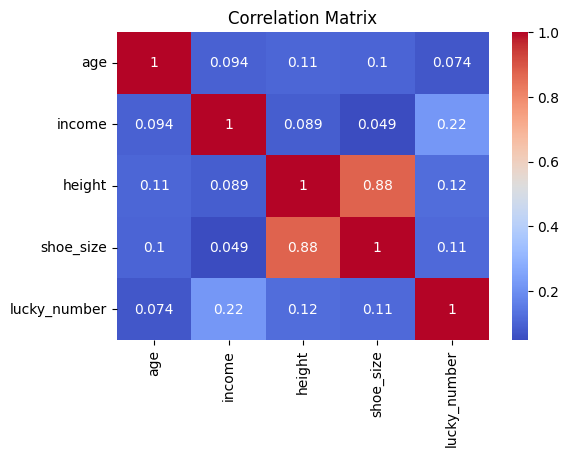

Dropped (high correlation): ['shoe_size']


In [4]:
corr_matrix = X.corr().abs()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Drop highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]

print("Dropped (high correlation):", to_drop)


In [5]:
from sklearn.feature_selection import chi2, SelectKBest

chi2_selector = SelectKBest(chi2, k=2)
X_chi2 = chi2_selector.fit_transform(X, y)

selected = X.columns[chi2_selector.get_support()]
print("Top features by Chi-Square:", list(selected))


Top features by Chi-Square: ['income', 'lucky_number']


Mutual Information Scores:
income          0.215966
age             0.048219
lucky_number    0.036203
shoe_size       0.016219
height          0.000000
dtype: float64


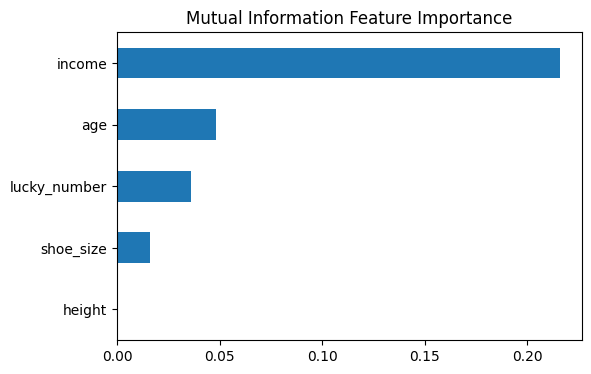

In [6]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns)

print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))

mi_scores.sort_values().plot.barh(figsize=(6,4))
plt.title("Mutual Information Feature Importance")
plt.show()


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

model = LogisticRegression(max_iter=500)
rfe = RFE(model, n_features_to_select=2)
rfe.fit(X, y)

selected = X.columns[rfe.support_]
print("Selected Features by RFE:", list(selected))


Selected Features by RFE: ['height', 'shoe_size']


In [8]:
import statsmodels.api as sm

def forward_selection(X, y):
    remaining = list(X.columns)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            model = sm.OLS(y, sm.add_constant(X[selected + [candidate]])).fit()
            score = model.aic
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    return selected

selected = forward_selection(X, y)
print("Selected Features by Stepwise Selection:", selected)


Selected Features by Stepwise Selection: ['income', 'age']


age             0.008518
income          0.000012
height         -0.002810
shoe_size       0.000000
lucky_number   -0.000558
dtype: float64


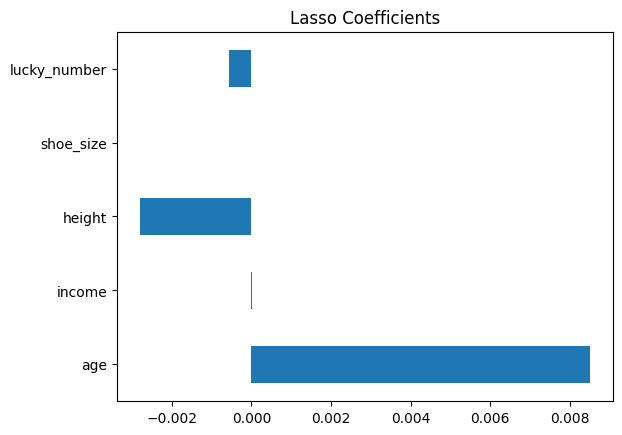

In [17]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01) # study its variance(alpha value)
lasso.fit(X, y)

lasso_coef = pd.Series(lasso.coef_, index=X.columns)
print(lasso_coef)

lasso_coef.plot(kind="barh") 
plt.title("Lasso Coefficients")
plt.show()


age             0.008612
income          0.000011
height         -0.004555
shoe_size       0.008146
lucky_number   -0.000598
dtype: float64


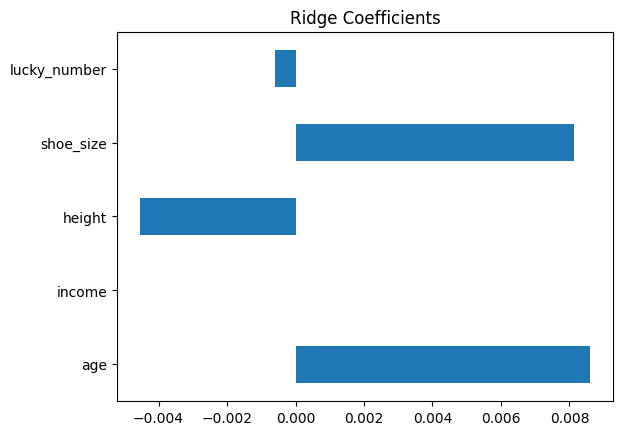

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

ridge_coef = pd.Series(ridge.coef_, index=X.columns)
print(ridge_coef)

ridge_coef.plot(kind="barh")#search what it does
plt.title("Ridge Coefficients") # negative meaning ?
plt.show()


age             0.008564
income          0.000012
height         -0.003493
shoe_size       0.003127
lucky_number   -0.000576
dtype: float64


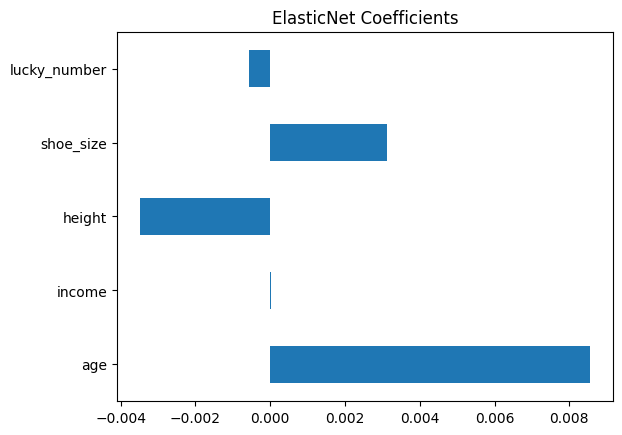

In [ ]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.01, l1_ratio=0.5) #l1 ratio ?
enet.fit(X, y)

enet_coef = pd.Series(enet.coef_, index=X.columns)
print(enet_coef)

enet_coef.plot(kind="barh")
plt.title("ElasticNet Coefficients")
plt.show()


age             0.151308
income          0.693179
height          0.119419
shoe_size       0.036094
lucky_number    0.000000
dtype: float64


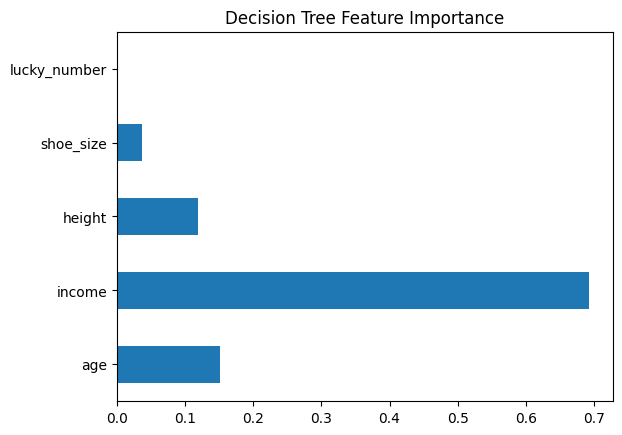

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

tree_importance = pd.Series(tree.feature_importances_, index=X.columns)
print(tree_importance)

tree_importance.plot(kind="barh")
plt.title("Decision Tree Feature Importance")
plt.show()


age             0.174729
income          0.487809
height          0.099707
shoe_size       0.110734
lucky_number    0.127022
dtype: float64


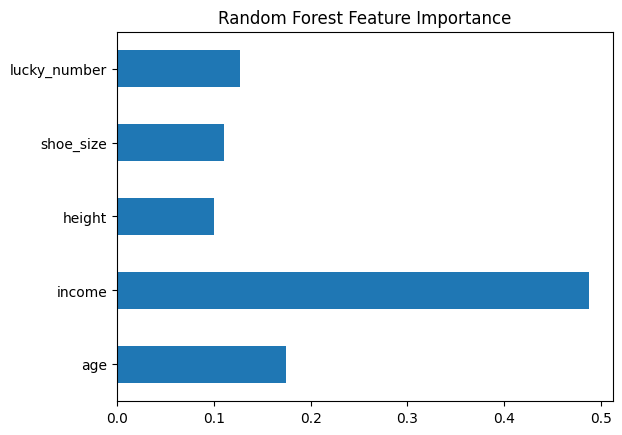

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
print(rf_importance)

rf_importance.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()


In [14]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X, y)

xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)
print(xgb_importance)

xgb_importance.plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.show()


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/tanish/code/Intro-AIML/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/tanish/code/Intro-AIML/.venv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [15]:
# Cell: Test XGBoost after libomp fix
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
print("✅ XGBoost Loaded Successfully!")


✅ XGBoost Loaded Successfully!


XGBoost Feature Importances:


/Users/tanish/code/Intro-AIML/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Feature,Importance
1,income,0.495094
0,age,0.251489
4,lucky_number,0.101917
2,height,0.076779
3,shoe_size,0.074720


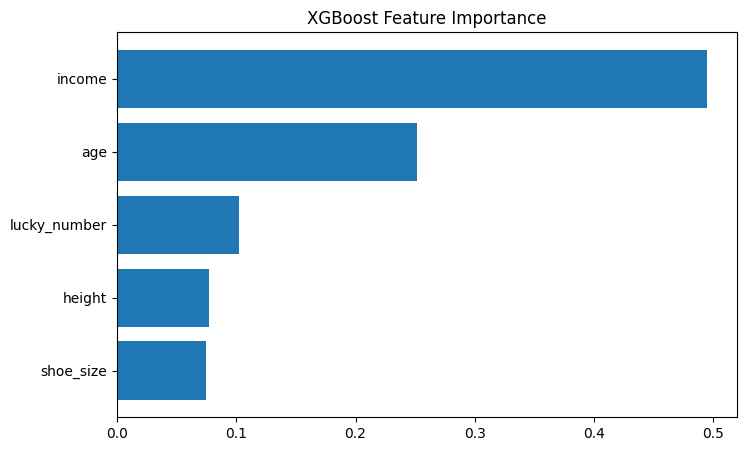

In [16]:
# Cell: XGBoost Feature Importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X, y)

# Get feature importances
xgb_importances = xgb.feature_importances_

# Show as DataFrame
xgb_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

print("XGBoost Feature Importances:")
display(xgb_df)

# Plot
plt.figure(figsize=(8,5))
plt.barh(xgb_df["Feature"], xgb_df["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()
